In [1]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute, transpile, Aer, IBMQ # circuit creation and execution
from qiskit.providers.aer.noise import NoiseModel # simulate backends
from qiskit.visualization import plot_histogram # visualize results
from qiskit.quantum_info import Statevector, state_fidelity, hellinger_fidelity # statevector and metrics
from qiskit.providers.ibmq import least_busy # get least busy device
import qiskit.tools.jupyter # visualize backends
from qiskit.circuit.library.standard_gates.rx import RXGate
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,CompleteMeasFitter, TensoredMeasFitter) # measurement error mitigation

import pandas as pd # handy tools for calculation
from numpy import pi

# global vars
n = 3 # number of qubits
shots = 1000 # high number of shots per execution

/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_8650/2212138642.py:8: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,CompleteMeasFitter, TensoredMeasFitter) # measurement error mitigation


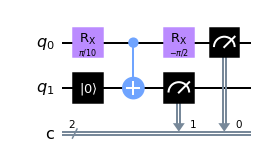

In [2]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.rx(pi*1/10, qreg_q[0])
circuit.reset(qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.rx(-pi/2, qreg_q[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[0], creg_c[0])
circuit.draw(output='mpl')

In [3]:
print(circuit.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
rx(pi/10) q[0];
reset q[1];
cx q[0],q[1];
rx(-pi/2) q[0];
measure q[1] -> c[1];
measure q[0] -> c[0];



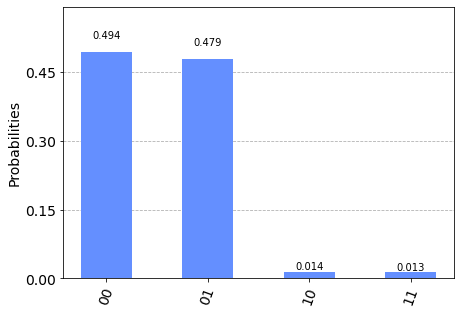

In [4]:
# Running the basic bomb tester circuit

from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

job = simulator.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts(circuit)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [5]:
expected_states = ['00', '01', '10', '11']  # target states

def get_state_accuracy(counts): # funciton to calculate state accuracy
    expected_counts = 0
    for state in counts.keys():
        if state in expected_states:
            expected_counts = expected_counts + counts[state]
    state_accuracy = expected_counts / shots
    return str(state_accuracy*100)+"%"

In [6]:
counts = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shots=shots).result().get_counts() # execution on simulator
state_accuracy = get_state_accuracy(counts)
print(f"state accuracy on the simulator: {state_accuracy}")

state accuracy on the simulator: 100.0%


In [7]:
from qiskit.test.mock import *

backends = [FakeVigo()]
backend1 = FakeVigo()

In [8]:
# compare transpiled circuits for different optimization levels on backend 1

optimization_levels = [0,1,2,3]
print("original circuit")
print(circuit)
for optim_level in optimization_levels:
    print(f"optimization level: {optim_level}")
    transpiled_circuit = transpile(circuit, backend=backend1, optimization_level=optim_level)
    print(transpiled_circuit)
    print(transpiled_circuit.qasm())

original circuit
     ┌──────────┐     ┌──────────┐┌─┐
q_0: ┤ Rx(π/10) ├──■──┤ Rx(-π/2) ├┤M├
     └──────────┘┌─┴─┐└───┬─┬────┘└╥┘
q_1: ────|0>─────┤ X ├────┤M├──────╫─
                 └───┘    └╥┘      ║ 
c: 2/══════════════════════╩═══════╩═
                           1       0 
optimization level: 0
global phase: π
               ┌─────────┐┌────┐┌────────────┐┌────┐┌──────────┐     »
      q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(11π/10) ├┤ √X ├┤ Rz(5π/2) ├──■──»
               └─────────┘└────┘└────────────┘└────┘└──────────┘┌─┴─┐»
      q_1 -> 1 ────|0>──────────────────────────────────────────┤ X ├»
                                                                └───┘»
ancilla_0 -> 2 ──────────────────────────────────────────────────────»
                                                                     »
ancilla_1 -> 3 ──────────────────────────────────────────────────────»
                                                                     »
ancilla_2 -> 4 ─────────────────────────

## Mitigation

In [9]:
# measurement error mitigation on backend 1

results_backend1_mem = []

# normal execution
noisy_counts = execute(circuit, backend=backend1, shots=shots, optimization_level=0).result().get_counts() # get results
noisy_state_accuracy = get_state_accuracy(noisy_counts) # calculate state accuracy from original results
results_backend1_mem.append(("noisy", noisy_counts, noisy_state_accuracy))

# measurement error mitigation
qr = QuantumRegister(n)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal') # setup calibration measures on basis states

cal_results = execute(meas_calibs, backend=backend1, shots=shots).result() # execute calibration measures
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter # get the filter object from calibration

mitigated_counts = meas_filter.apply(noisy_counts) # apply filter to get mitigated results
mitigated_state_accuracy = get_state_accuracy(mitigated_counts) # calculate state accuracy from mitigated results
results_backend1_mem.append(("mitigated", mitigated_counts, mitigated_state_accuracy))

# compare state accuracies
print("State Accuracy \n"+
      "\n".join([str(label)+': '+str(state_accuracy) for label, counts, state_accuracy in results_backend1_mem]))

# plot results
plot_histogram([counts for optim_level, counts, state_accuracy in results_backend1_mem],
               legend=[label for label, counts, state_accuracy in results_backend1_mem],
               title=backend1.name(),
               bar_labels=False)

QiskitError: "Unexpected state label '10', verify the fitter's state labels correspond to the input data"